In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1pRQYAsF99juyeXiavVM186bDDIaS_z8o
!gdown --id 1gNo2xpL8SFzgYWTNK_zdkivD1j0AKSgV

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiPtRAfdLFRjBtBu8pdP-9G5YRoG1J5iUsfYM7qgBXPhEagxhUXOuM
Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1pRQYAsF99juyeXiavVM186bDDIaS_z8o
To: /content/AirQualityUCI.csv
100% 785k/785k [00:00<00:00, 51.7MB/s]


In [ ]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3 MB 1.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:


In [ ]:
import scipy
from scipy import stats
from scipy.stats import norm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set(style="whitegrid", palette="Accent")

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png') # svg

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn import set_config 
set_config(display='diagram')

import warnings
warnings.filterwarnings('ignore')

# Support

In [ ]:
def imp_graph(est, columns):
    data = pd.DataFrame(est.coef_.reshape(-1,1), columns=["imp"], index=columns)
    data.reset_index(inplace=True)
    fig = plt.figure(figsize=(10,6))
    sns.barplot(x='imp', y='index', data=data)
    plt.show()

In [ ]:
def check_nan(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    indexes = missing_data.loc[missing_data.Percent > .01].index.values
    if not missing_data.loc[missing_data.Total > 0].index.tolist():
        print("There are no missing values") 
    else:
        print(missing_data.loc[missing_data.Total > 0])
    pass

In [ ]:
def count_nan(data, feature_name):
    fig, axes = plt.subplots(1,3, figsize=(20,4))
    for i, column in enumerate(["hour", "month", "day"]):
        sns.countplot(x=column,  data=data.loc[data[feature_name].isnull(), [column]], ax=axes[i], palette="Accent")
    fig.suptitle("Count of NaN for " + feature_name + " feature")
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    pass

In [ ]:
def dist_graph(data, target_col):
    sns.set(style="white", palette="brg_r")
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    alpha = 1e-3
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")
    if p < alpha:  # 
        print("The null hypothesis can be rejected")
        print("Oops, We shoukd try to transform the distribution!")
    else:
        print("The null hypothesis cannot be rejected")

    if p < alpha:
        data.loc[:, target_col+'_box'], lmbda = stats.boxcox(data.loc[:, target_col])
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(data.loc[:, target_col+'_box'], fit=norm, ax=axes[0]);
        res = stats.probplot(data.loc[:, target_col+'_box'], plot=axes[1])
        plt.tight_layout()
        plt.show()

        #skewness and kurtosis
        print("Skewness: %f" % data.loc[:, target_col+'_box'].skew())
        print("Kurtosis: %f" % data.loc[:, target_col+'_box'].kurt(), "\n")

        k2, p = stats.normaltest(data.loc[:, target_col+'_box'])
        alpha = 1e-3
        print("null hypothesis: x comes from a normal distribution")
        print(f"p_value = {p}, {k2}")
        if p < alpha:  # 
            print("The null hypothesis still can be rejected")
            print("But we did our best")
        else:
            print("The null hypothesis cannot be rejected now")
    return data.loc[:, target_col+'_box'], lmbda

In [ ]:
def count_nan_inarow(series):
    dict_ = {}
    previous_is_na = False
    i = 0
    for element in series.replace(np.nan, "NaN"):
        if element == "NaN":
            if previous_is_na:
                dict_[i] -= 1
                i += 1
                if dict_.get(i, "ups") == "ups":
                    dict_[i] = 1
                else:
                    dict_[i] += 1
            else:
                i += 1
                if dict_.get(i, "ups") == "ups":
                    dict_[i] = 1
                else:
                    dict_[i] += 1
                previous_is_na = True
        else:
            previous_is_na = False
            i = 0
    dict_ = {k: v for k, v in dict_.items() if v != 0}
    print("We've got:")
    [print(f"{v} cases with {k} missing values in a row") for k, v in dict_.items()]
    pass

In [ ]:
def cv_curve(param_name, mean_test, std_test, mean_train, std_train, param_val, x_type, param_scale="log"):
    #try:
    #    param_val.sort()
    #except:
    #    pass
    lower_b_tt = mean_test - 2*std_test
    upper_b_tt= mean_test + 2*std_test
    
    lower_b_tn = mean_train - 2*std_train
    upper_b_tn = mean_train + 2*std_train
    
    f = plt.figure(figsize=(13,5))
    plt.title('choose ' + param_name)
    
    if x_type == 'O':
        plt.plot(range(len(param_val)), mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(range(len(param_val)), lower_b_tt, label='test lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tt, label='test upper bound', color='b', lw=2, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)

        plt.plot(range(len(param_val)), mean_train, label='train mean values of score', color='gray', lw=1)
        plt.plot(range(len(param_val)), lower_b_tn, label='train lower bound', color='gray', lw=1, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tn, label='train upper bound', color='gray', lw=1, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)
    else:
        if param_scale =='log':
            plt.xscale('log')
        plt.plot(param_val, mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(param_val, lower_b_t, label='lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(param_val, upper_b_t, label='upper bound', color='b', lw=2, linestyle='dashed')
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor('white')
    legend_box.set_edgecolor('red')
    plt.xlabel('parameter')
    plt.ylabel('neg_mae')
    plt.show()

# Dataset description

In [ ]:
# Read dataset and replace all -200 values to np.nan
data = pd.read_csv("./AirQualityUCI.csv", sep=';', decimal=',', parse_dates=True)
data.drop(columns=["Unnamed: 15", "Unnamed: 16"], inplace=True)
data.dropna(inplace=True)
data.replace(-200, np.nan, inplace=True)

In [ ]:
# Dataset description
!head -n 22 "/content/data.txt"

Main link: https://archive.ics.uci.edu/ml/datasets/Air+Quality#
Data Set Information:
The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [ ]:
# drop column "NMHC(GT)" bacause of lack of usefull observations
data.drop(columns=["NMHC(GT)"], inplace=True)

In [ ]:
# We've got 2 object variables: Date and Time
# Let's extract day number, month number and hour of measurements  
data.loc[:, 'hour'] = data.loc[:, 'Time'].str[:2].astype(int)
data.loc[:, "month"] = pd.DatetimeIndex(data.loc[:, "Date"]).month
data.loc[:, "day"] = pd.DatetimeIndex(data.loc[:, "Date"]).day
data.Date = pd.to_datetime(data.Date, dayfirst=True)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CO(GT),7674.0,2.152750,1.453252,0.1000,1.1000,1.8000,2.9000,11.900
PT08.S1(CO),8991.0,1099.833166,217.080037,647.0000,937.0000,1063.0000,1231.0000,2040.000
C6H6(GT),8991.0,10.083105,7.449820,0.1000,4.4000,8.2000,14.0000,63.700
PT08.S2(NMHC),8991.0,939.153376,266.831429,383.0000,734.5000,909.0000,1116.0000,2214.000
NOx(GT),7718.0,246.896735,212.979168,2.0000,98.0000,180.0000,326.0000,1479.000
PT08.S3(NOx),8991.0,835.493605,256.817320,322.0000,658.0000,806.0000,969.5000,2683.000
NO2(GT),7715.0,113.091251,48.370108,2.0000,78.0000,109.0000,142.0000,340.000
PT08.S4(NO2),8991.0,1456.264598,346.206794,551.0000,1227.0000,1463.0000,1674.0000,2775.000
PT08.S5(O3),8991.0,1022.906128,398.484288,221.0000,731.5000,963.0000,1273.5000,2523.000
T,8991.0,18.317829,8.832116,-1.9000,11.8000,17.8000,24.4000,44.600


# Data Preparation. Part 1

## The first batch of NAN

In [ ]:
# As we see there are 366 timestamps where equipment did not work
# Now let's check if there are any dependencies with day, month, or hours

with pd.option_context('display.max_rows', None, 'display.max_columns', 9):
    print(data.loc[data["AH"].isnull(), :].head())
check_nan(data)

          Date      Time  CO(GT)  PT08.S1(CO)  ...  AH  hour  month  day
524 2004-04-01  14.00.00     1.7          NaN  ... NaN    14      1    4
525 2004-04-01  15.00.00     1.9          NaN  ... NaN    15      1    4
526 2004-04-01  16.00.00     2.3          NaN  ... NaN    16      1    4
701 2004-04-08  23.00.00     2.0          NaN  ... NaN    23      8    4
702 2004-04-09  00.00.00     2.4          NaN  ... NaN     0      9    4

[5 rows x 17 columns]
               Total   Percent
CO(GT)          1683  0.179865
NO2(GT)         1642  0.175484
NOx(GT)         1639  0.175163
PT08.S1(CO)      366  0.039115
AH               366  0.039115
RH               366  0.039115
T                366  0.039115
PT08.S5(O3)      366  0.039115
PT08.S4(NO2)     366  0.039115
PT08.S3(NOx)     366  0.039115
PT08.S2(NMHC)    366  0.039115
C6H6(GT)         366  0.039115


In [ ]:
count_nan_inarow(data.loc[:, 'AH'])

We've got:
3 cases with 1 missing values in a row
1 cases with 3 missing values in a row
1 cases with 4 missing values in a row
1 cases with 5 missing values in a row
1 cases with 8 missing values in a row
1 cases with 9 missing values in a row
1 cases with 10 missing values in a row
1 cases with 14 missing values in a row
1 cases with 24 missing values in a row
1 cases with 38 missing values in a row
1 cases with 45 missing values in a row
1 cases with 52 missing values in a row
1 cases with 75 missing values in a row
1 cases with 76 missing values in a row


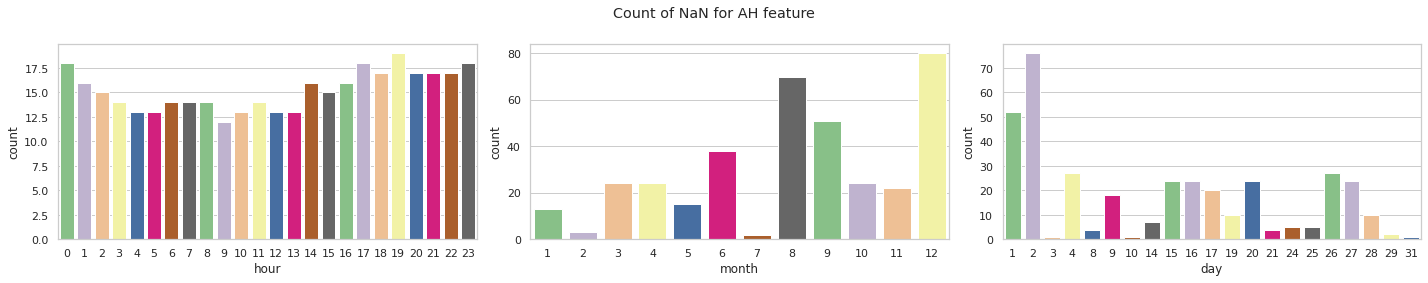

In [ ]:
# Check features with 366 missing values

count_nan(data=data.copy(), feature_name="AH")

# So as we see there are no dependencies with hour or month
# But it seems like the equipment did not work at the beginning of the month more often then in other cases
# I think that the proper way is just to remove all of it

In [ ]:
# I've just noticed that there are missing values in our target too
# So lets drop it and then we will divide our dataset inro two parts: train and test
# drop rows with Nan in target
data.drop(data.loc[data["AH"].isnull(), :].index, inplace=True)

## Train/test split

In [ ]:
# dividing dataset
# As was said in the description, data were recorded from March 2004 to February 2005 (one year)
# representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses.
# but real data date range is:
print(f"min: {data.Date.min()},  max: {data.Date.max()}")
print("There are 14 months in dataset")

min: 2004-03-10 00:00:00,  max: 2005-04-04 00:00:00
There are 14 months in dataset


In [ ]:
# Let's use 12 months for training our model and keep 2 months for testing
train = data.loc[(data.Date >= "2004-03-10") & (data.Date <= "2005-03-10")]
test = data.loc[data.Date > "2005-03-10"]

test_share = test.shape[0]/(train.shape[0]+test.shape[0])

print(f"there are {test_share*100:.03}% of observations in our test sample")
print("it's not really big, but it seems right")

there are 6.56% of observations in our test sample
it's not really big, but it seems right


In [ ]:
train.drop(columns=["Date", "Time"], inplace=True)

## The second batch of NAN

In [ ]:
print(train.loc[train["NO2(GT)"].isnull(), ['NO2(GT)', 'NOx(GT)', "CO(GT)"]].head(10))
check_nan(train)

     NO2(GT)  NOx(GT)  CO(GT)
9        NaN      NaN     0.6
33       NaN      NaN     0.8
39       NaN      NaN     NaN
57       NaN      NaN     1.7
81       NaN      NaN     2.4
105      NaN      NaN     1.1
129      NaN      NaN     0.7
153      NaN      NaN     0.7
177      NaN      NaN     0.7
201      NaN      NaN     0.7
         Total   Percent
CO(GT)    1628  0.193786
NO2(GT)   1598  0.190215
NOx(GT)   1595  0.189858


In [ ]:
count_nan_inarow(train.loc[:, 'NOx(GT)'])

We've got:
309 cases with 1 missing values in a row
2 cases with 2 missing values in a row
1 cases with 5 missing values in a row
2 cases with 12 missing values in a row
1 cases with 20 missing values in a row
1 cases with 24 missing values in a row
1 cases with 29 missing values in a row
1 cases with 32 missing values in a row
1 cases with 33 missing values in a row
1 cases with 39 missing values in a row
1 cases with 41 missing values in a row
1 cases with 46 missing values in a row
1 cases with 48 missing values in a row
1 cases with 54 missing values in a row
1 cases with 57 missing values in a row
1 cases with 73 missing values in a row
1 cases with 84 missing values in a row
1 cases with 96 missing values in a row
1 cases with 116 missing values in a row
1 cases with 142 missing values in a row
1 cases with 146 missing values in a row
1 cases with 173 missing values in a row


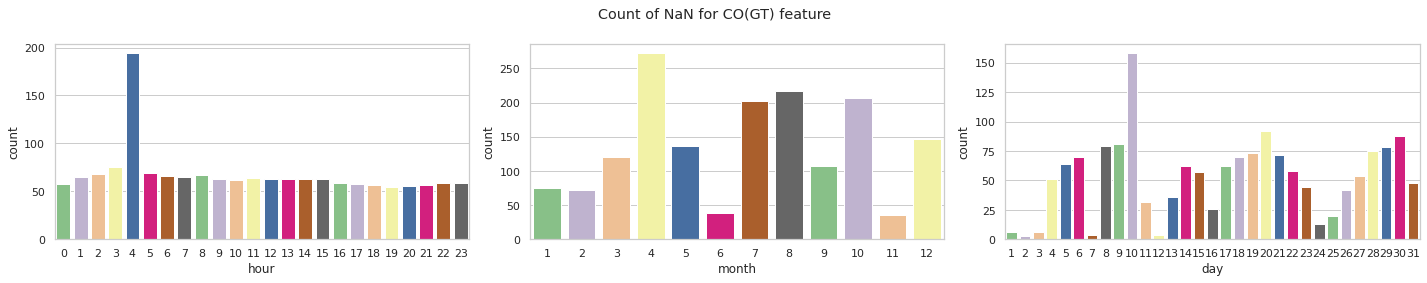

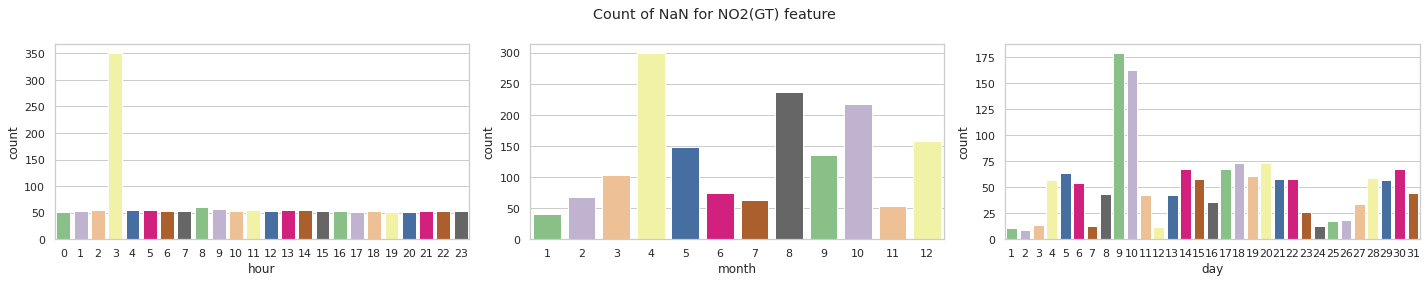

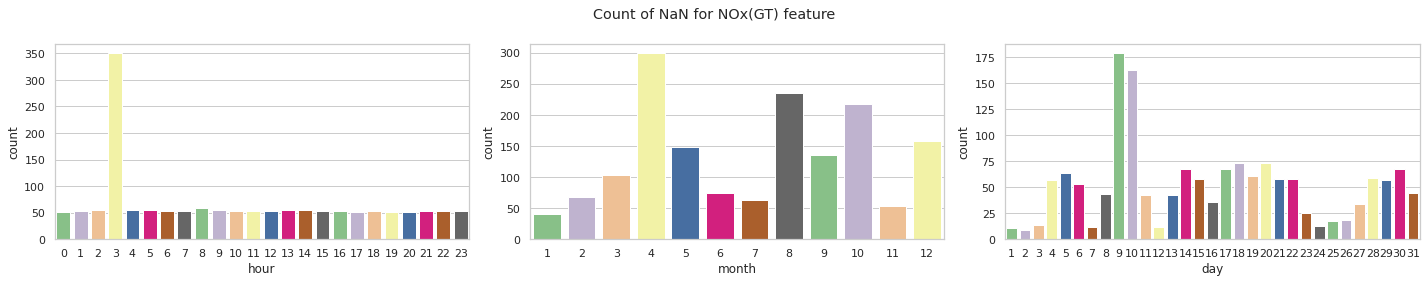

In [ ]:
# As we see, missing values of CO(G), NO2(GT), NOx(GT) is distributed pretty similar over time.
# Maybe there are some connections with maintenance cycles 

count_nan(data=train.copy(), feature_name="CO(GT)")
count_nan(data=train.copy(), feature_name="NO2(GT)")
count_nan(data=train.copy(), feature_name="NOx(GT)")

So, even though data has a time-series nature, there is no way to use a forward fill imputer because of the huge amount of missing observations wich comes in a row.

So lets test KNN Imputer

In [ ]:
imputer = KNNImputer(n_neighbors=5)
train = pd.DataFrame(data=imputer.fit_transform(train), columns=train.columns)

In [ ]:
check_nan(train)

There are no missing values


# EDA & FE

## Univariate analysis

Now let's work with features distributions. There are a lot of continuous features and all of them want to be just normal

---
---

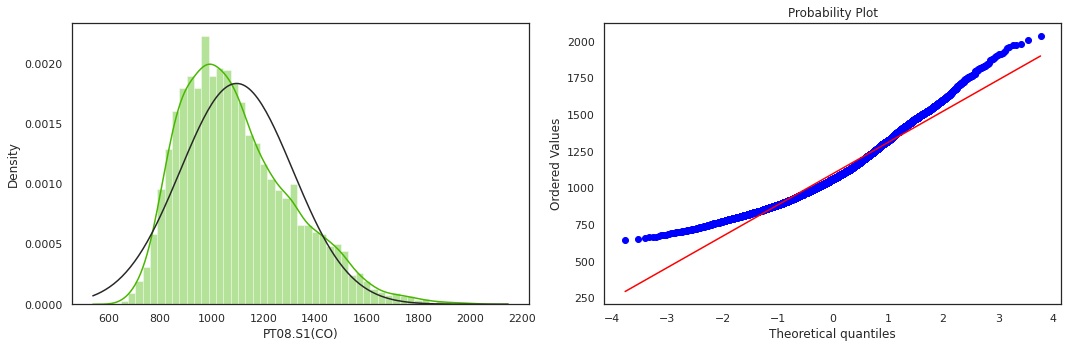

Skewness: 0.777009
Kurtosis: 0.383554 

null hypothesis: x comes from a normal distribution
p_value = 2.1603997627506833e-154, 707.6556220823275
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


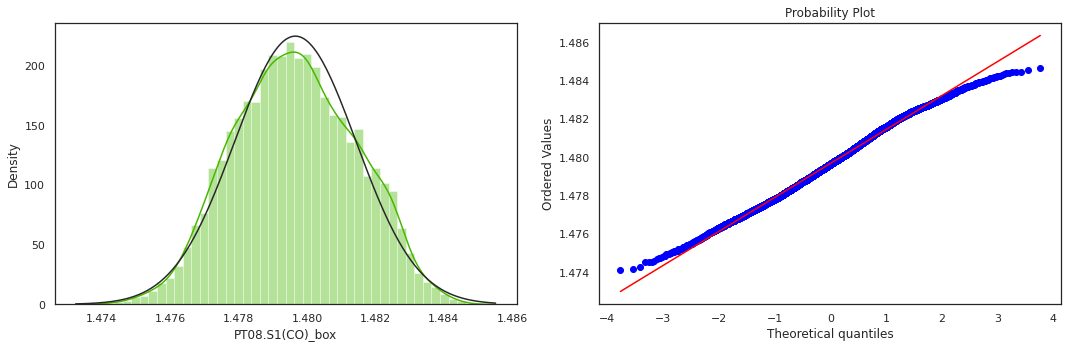

Skewness: 0.021355
Kurtosis: -0.478862 

null hypothesis: x comes from a normal distribution
p_value = 7.823663784205898e-32, 143.25114003273322
The null hypothesis still can be rejected
But we did our best


In [ ]:
 train.loc[:, 'PT08.S1(CO)'], lmbda_s1 = dist_graph(train.copy(), target_col='PT08.S1(CO)')

---
---

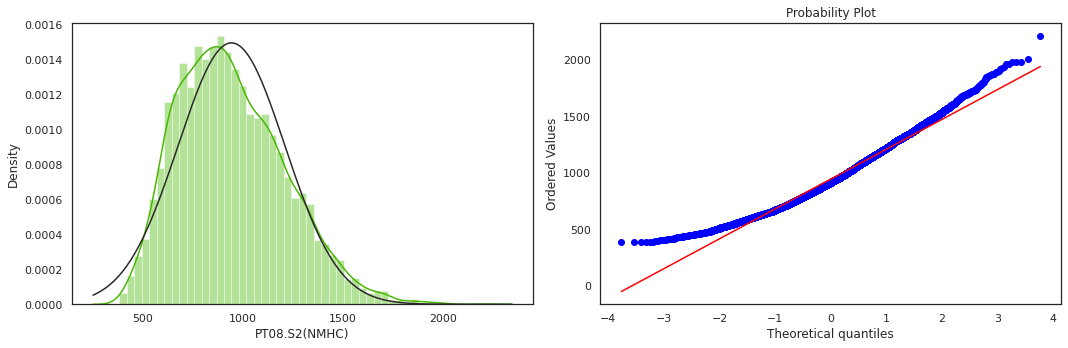

Skewness: 0.551609
Kurtosis: 0.080032 

null hypothesis: x comes from a normal distribution
p_value = 1.934268147260761e-82, 376.30449717808506
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


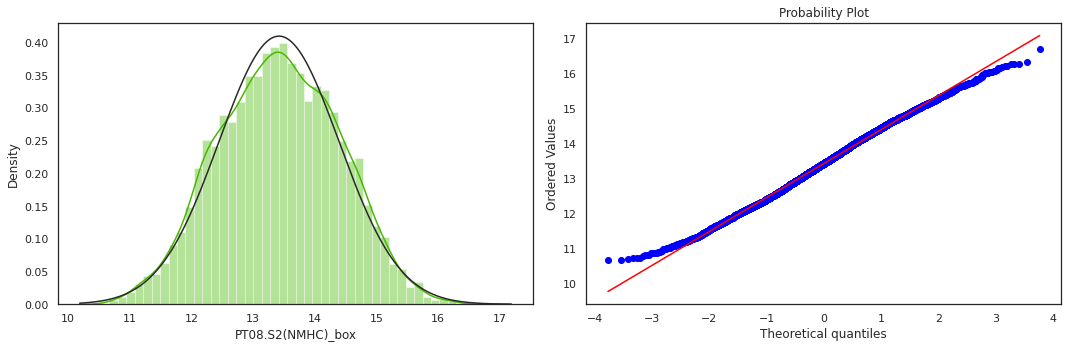

Skewness: -0.007151
Kurtosis: -0.413851 

null hypothesis: x comes from a normal distribution
p_value = 8.456181961564325e-22, 97.04394855779832
The null hypothesis still can be rejected
But we did our best


In [ ]:
train.loc[:, 'PT08.S2(NMHC)'], lmbda_s2 = dist_graph(train.copy(), target_col='PT08.S2(NMHC)')

---
---

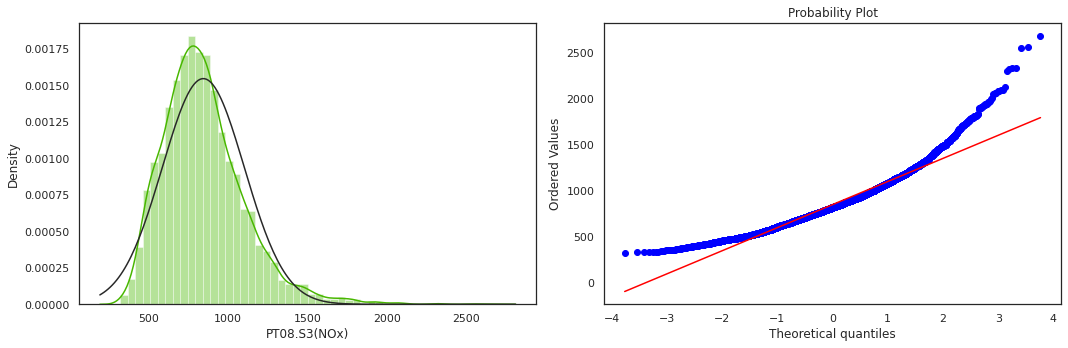

Skewness: 1.110842
Kurtosis: 2.685799 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 1697.39483867368
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


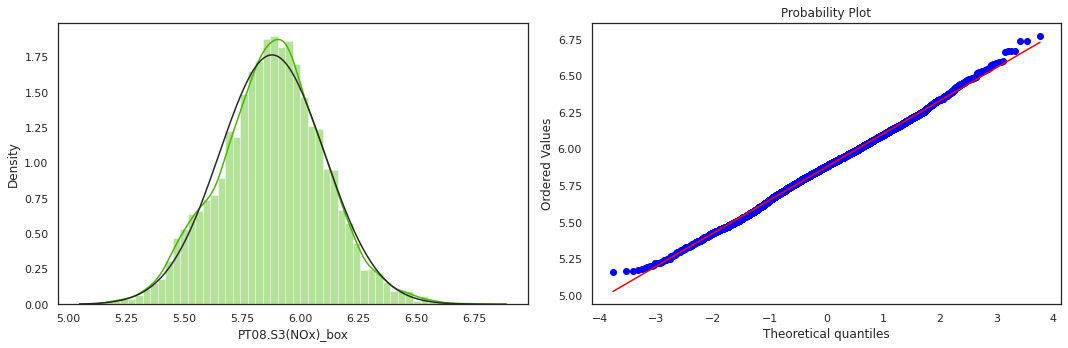

Skewness: -0.000466
Kurtosis: 0.116309 

null hypothesis: x comes from a normal distribution
p_value = 0.11321061989802263, 4.357010604519766
The null hypothesis cannot be rejected now


In [ ]:
train.loc[:, 'PT08.S3(NOx)'], lmbda_s3 = dist_graph(train.copy(), target_col='PT08.S3(NOx)')

---
---

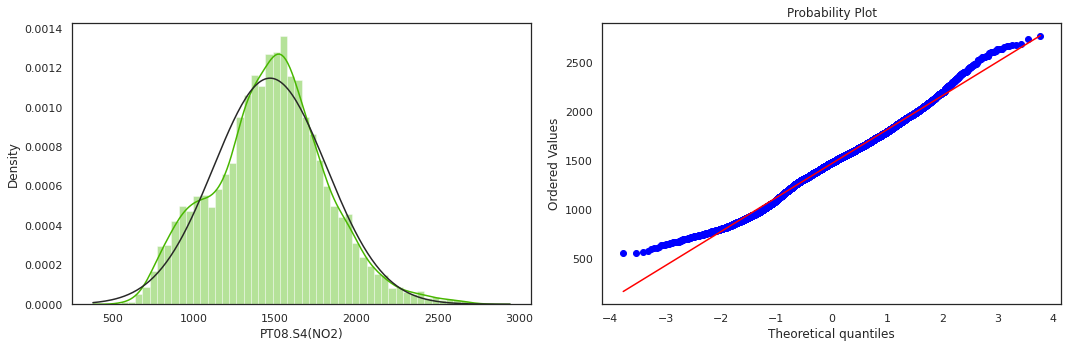

Skewness: 0.155903
Kurtosis: 0.093434 

null hypothesis: x comes from a normal distribution
p_value = 1.1483291925299064e-08, 36.56474546817193
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


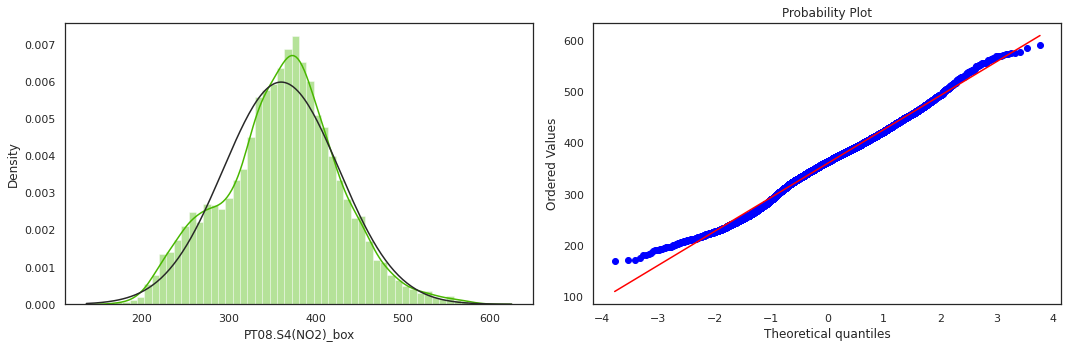

Skewness: -0.007280
Kurtosis: -0.011975 

null hypothesis: x comes from a normal distribution
p_value = 0.9446235546930561, 0.11393757134983351
The null hypothesis cannot be rejected now


In [ ]:
train.loc[:, 'PT08.S4(NO2)'], lmbda_s4 = dist_graph(train.copy(), target_col='PT08.S4(NO2)')

---
---

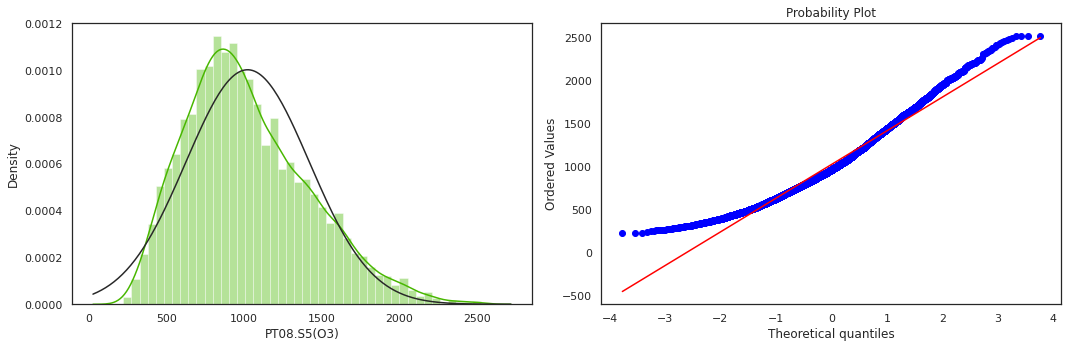

Skewness: 0.641745
Kurtosis: 0.127519 

null hypothesis: x comes from a normal distribution
p_value = 1.2969315981122257e-107, 492.23320756992075
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


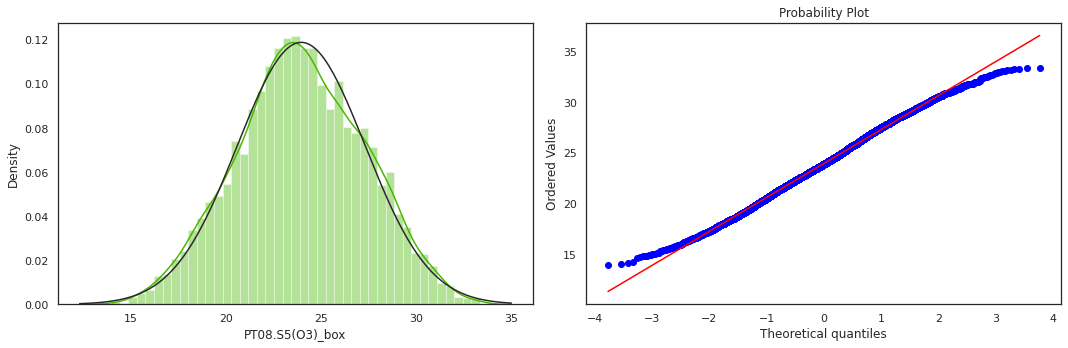

Skewness: -0.015001
Kurtosis: -0.357433 

null hypothesis: x comes from a normal distribution
p_value = 2.459055035596621e-15, 67.2779985012705
The null hypothesis still can be rejected
But we did our best


In [ ]:
train.loc[:, 'PT08.S5(O3)'], lmbda_s5 = dist_graph(train.copy(), target_col='PT08.S5(O3)')

---
---

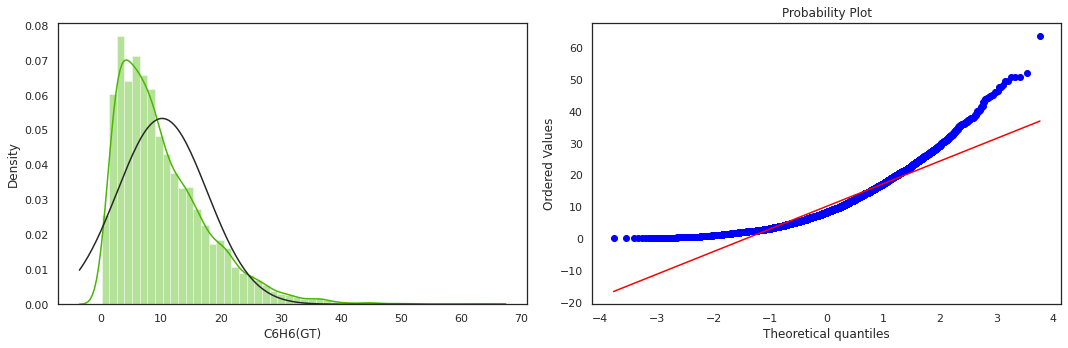

Skewness: 1.360727
Kurtosis: 2.520347 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 2043.313047462018
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


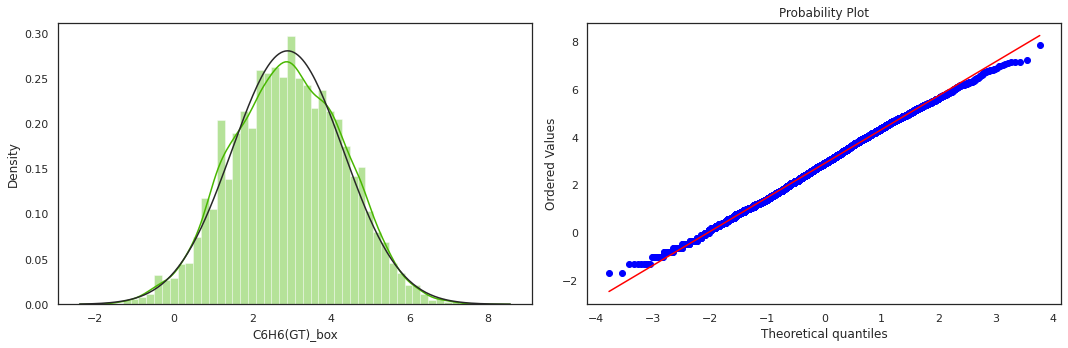

Skewness: -0.023904
Kurtosis: -0.296586 

null hypothesis: x comes from a normal distribution
p_value = 3.795944379735888e-10, 43.38383540327048
The null hypothesis still can be rejected
But we did our best


In [ ]:
train.loc[:, 'C6H6(GT)'], lmbda_c6h6 = dist_graph(train.copy(), target_col='C6H6(GT)')

---
---

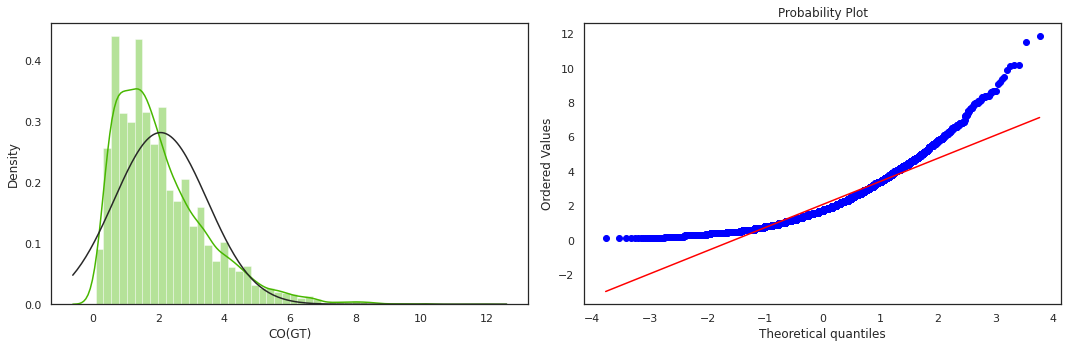

Skewness: 1.401149
Kurtosis: 2.791585 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 2158.831096578998
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


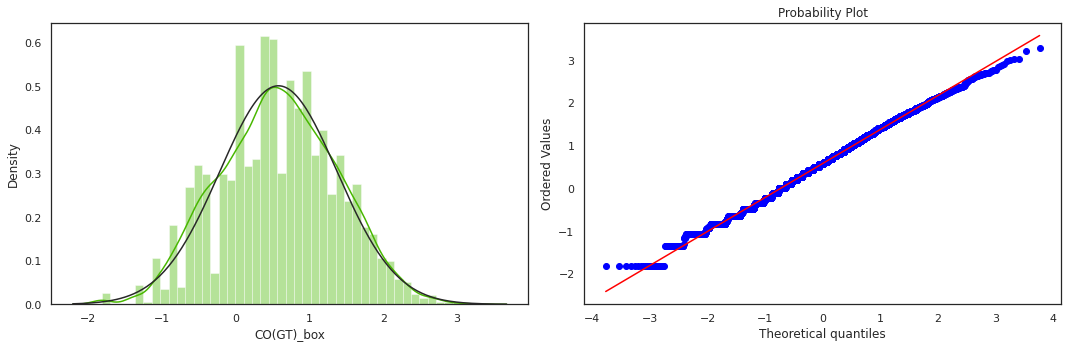

Skewness: -0.015215
Kurtosis: -0.285750 

null hypothesis: x comes from a normal distribution
p_value = 2.9090974964698267e-09, 39.31084588507223
The null hypothesis still can be rejected
But we did our best


In [ ]:
# missing_values
train.loc[:, 'CO(GT)'], lmbda_co = dist_graph(train.copy(), target_col='CO(GT)')

---
---

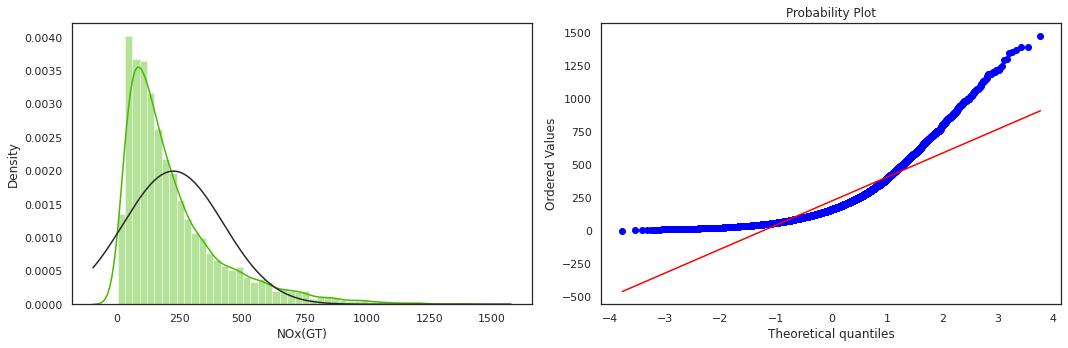

Skewness: 1.817577
Kurtosis: 3.963532 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 2987.913734008389
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


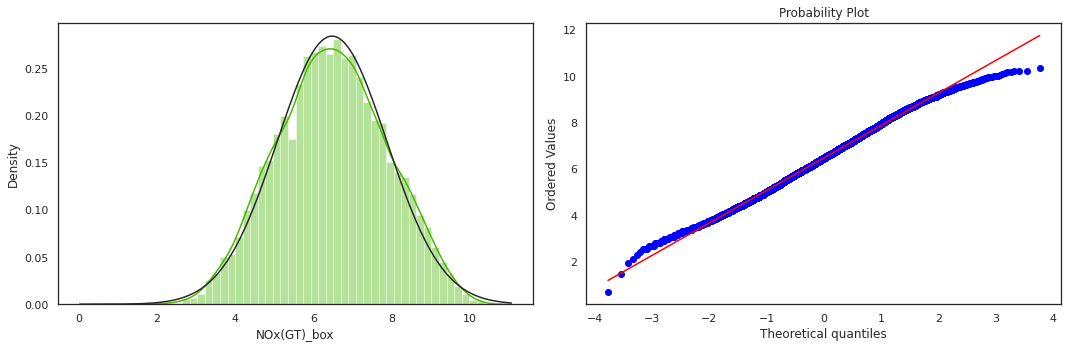

Skewness: -0.010758
Kurtosis: -0.406019 

null hypothesis: x comes from a normal distribution
p_value = 8.268841496402335e-21, 92.48358507746102
The null hypothesis still can be rejected
But we did our best


In [ ]:
# missing_values
train.loc[:, 'NOx(GT)'], lmbda_nox = dist_graph(train.copy(), target_col='NOx(GT)')

---
---

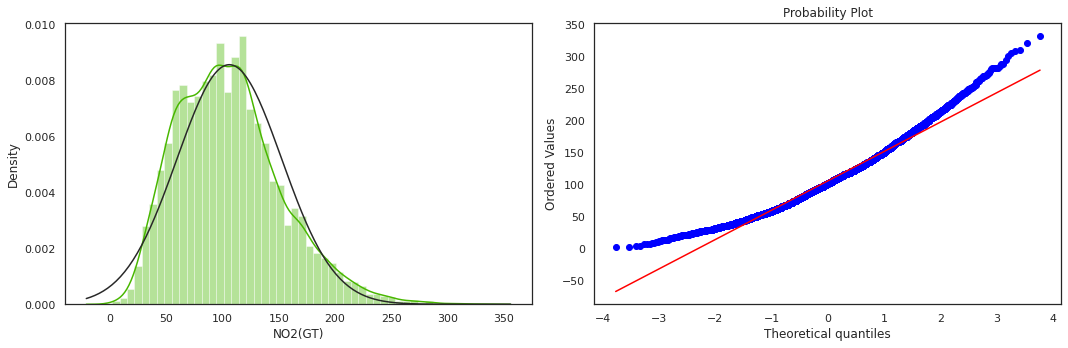

Skewness: 0.671885
Kurtosis: 0.536609 

null hypothesis: x comes from a normal distribution
p_value = 4.598045757203228e-129, 591.0156912367911
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


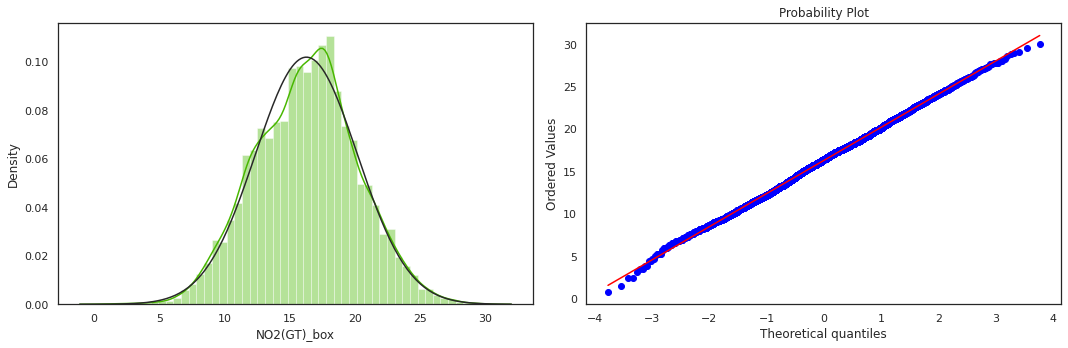

Skewness: -0.007439
Kurtosis: -0.096776 

null hypothesis: x comes from a normal distribution
p_value = 0.16456826621444617, 3.6088596053541373
The null hypothesis cannot be rejected now


In [ ]:
# missing_values
train.loc[:, 'NO2(GT)'], lmbda_no2 = dist_graph(train.copy(), target_col='NO2(GT)')

---
---

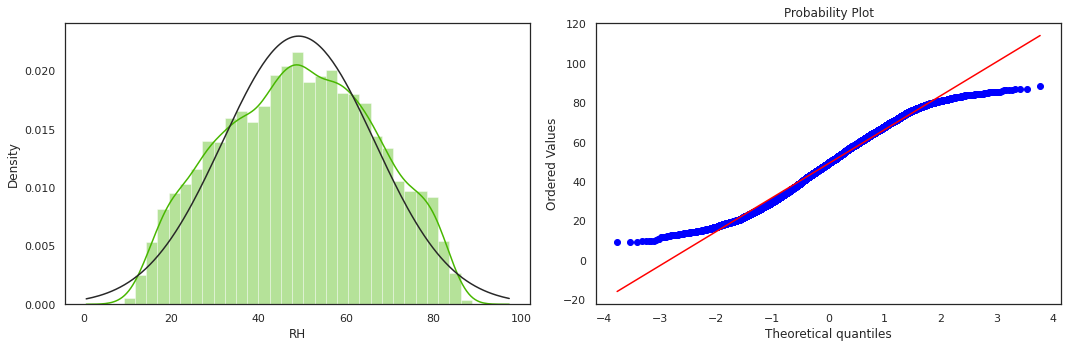

Skewness: -0.024989
Kurtosis: -0.819003 

null hypothesis: x comes from a normal distribution
p_value = 6.0740435861593074e-170, 779.2708825330647
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


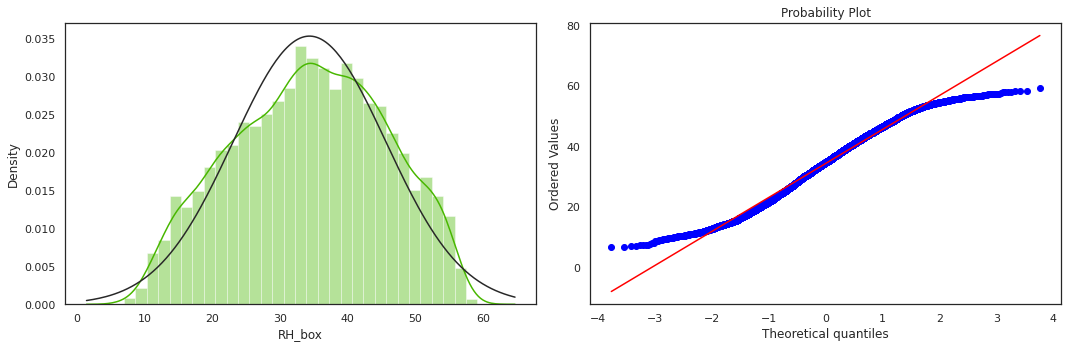

Skewness: -0.103066
Kurtosis: -0.792573 

null hypothesis: x comes from a normal distribution
p_value = 4.655767270911988e-153, 701.5148250073578
The null hypothesis still can be rejected
But we did our best


In [ ]:
train.loc[:, 'RH'], lmbda_rh = dist_graph(train.copy(), target_col='RH')

---
---

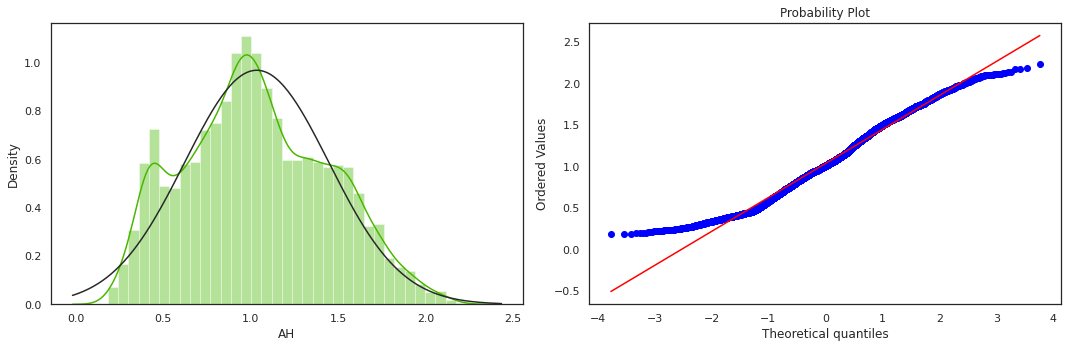

Skewness: 0.204929
Kurtosis: -0.637416 

null hypothesis: x comes from a normal distribution
p_value = 3.1503311891821333e-84, 384.5392804495323
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


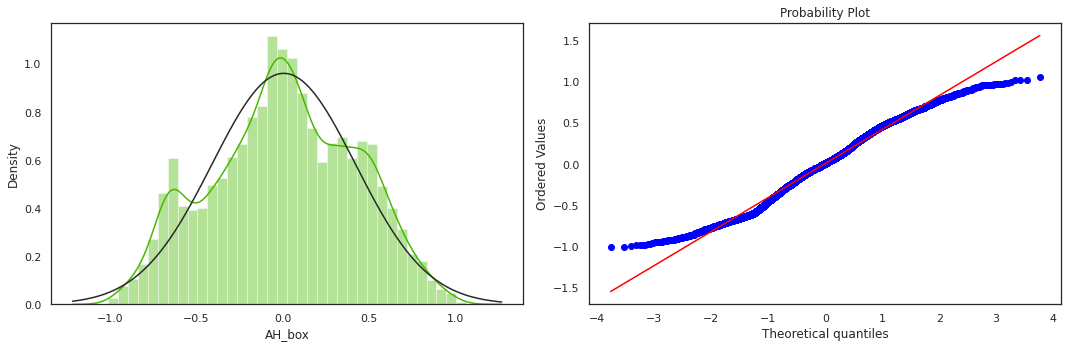

Skewness: -0.073471
Kurtosis: -0.664452 

null hypothesis: x comes from a normal distribution
p_value = 2.385580106002704e-83, 380.49024078542595
The null hypothesis still can be rejected
But we did our best


In [ ]:
train.loc[:, 'AH'], lmbda_ah = dist_graph(train.copy(), target_col='AH')

## Multivariate analysis

### Categorical features

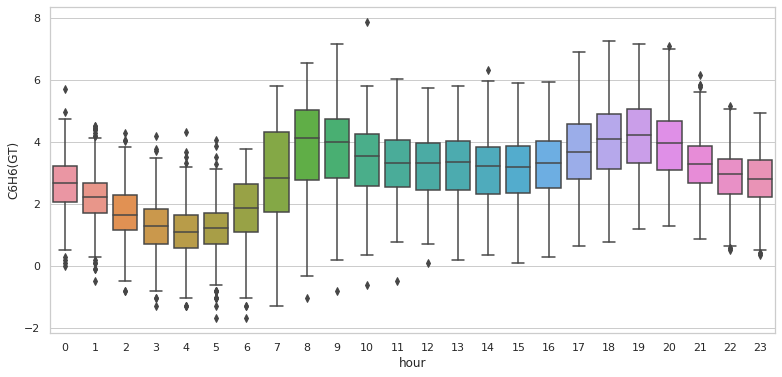

In [ ]:
# box plot "hour"
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(13, 6))
train.loc[:, 'hour'] = train.loc[:, 'hour'].astype("int")
fig = sns.boxplot(x='hour', y='C6H6(GT)', data=train.loc[:, ['C6H6(GT)', 'hour']])
plt.show()

# it seems like there is a nonlinear correlation between C6H6 (GT) and hour
# Let's combine "hour" into bigger bins and then apply OHE to it 

In [ ]:
# We will create 3 degree: low(0), medium(1), high(2)
bin_low = [1, 2, 3, 4, 5, 6]
bin_high = [8, 9, 10, 17, 18, 19, 20]
bin_medium = [x for x in range(0, 24) if x not in bin_low+bin_high]

train.loc[:, 'degree'] = 1
train.loc[train["hour"].isin(bin_low), 'degree'] = 0
train.loc[train["hour"].isin(bin_high), 'degree'] = 2

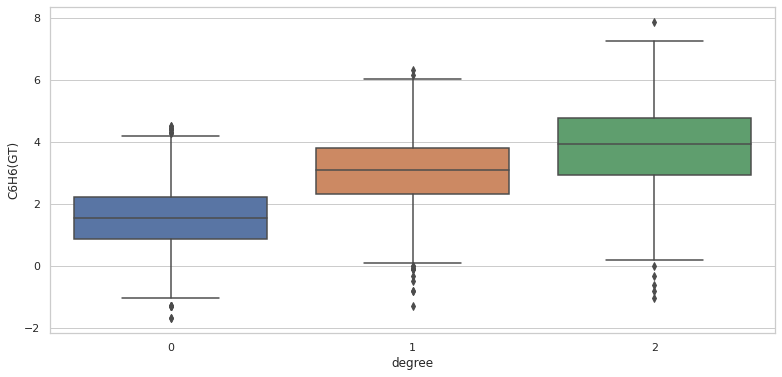

In [ ]:
# box plot "degree"
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(13, 6))
fig = sns.boxplot(x='degree', y='C6H6(GT)', data=train.loc[:, ['C6H6(GT)', 'degree']])
plt.show()

# looks good

In [ ]:
train.drop(columns=["hour"], inplace=True)

In [ ]:
sample_1, sample_2 = train.loc[train["degree"]==0, 'C6H6(GT)'], train.loc[train["degree"]==1, 'C6H6(GT)']
sample_3 = train.loc[train["degree"]==2, 'C6H6(GT)'] 
# Check that samples means are different
stats.f_oneway(sample_1, sample_2, sample_3)

# There is sufficient evidence at the level 0.05 that there is a difference in groups means.

F_onewayResult(statistic=2426.5758743965002, pvalue=0.0)

---

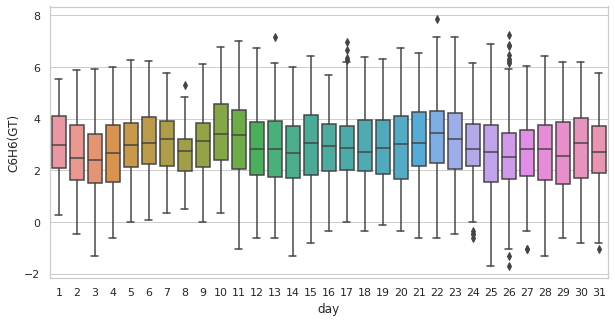

In [ ]:
# box plot "day"
f, ax = plt.subplots(figsize=(10, 5))
train.loc[:, 'day'] = train.loc[:, 'day'].astype("int")
fig = sns.boxplot(x='day', y='C6H6(GT)', data=train.loc[:, ['C6H6(GT)', 'day']])
plt.show()

# I don't think that there are any correlations between C6H6 (GT) and day
# We can drop that column later

---

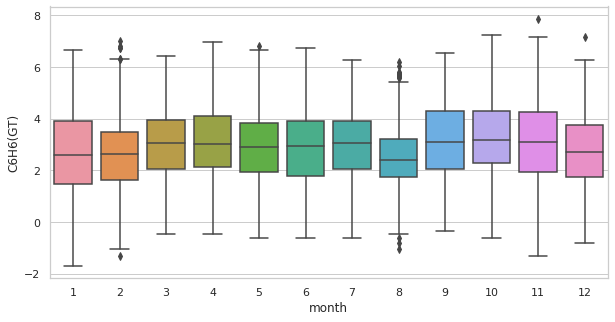

In [ ]:
# box plot "month"
f, ax = plt.subplots(figsize=(10, 5))
train.loc[:, 'month'] = train.loc[:, 'month'].astype("int")
fig = sns.boxplot(x='month', y='C6H6(GT)', data=train.loc[:, ['C6H6(GT)', 'month']])
plt.show()

# I don't think that there are strong correlations between C6H6 (GT) and month
# Let's try to drop that column later

___

### Numerical features analysis

In [ ]:
sns.set(style="whitegrid", palette="Dark2")
sns.pairplot(train.drop(columns=["degree", "month", "day"]))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

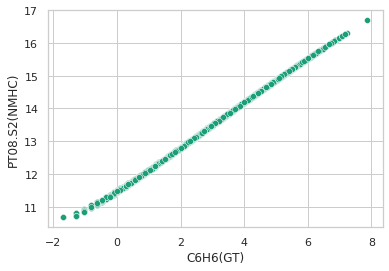

In [ ]:
# lol, kek, cheburek
# As we see there are strong linear dependence between these two variables
sns.set(style="whitegrid", palette="Dark2")
sns.scatterplot(x = 'C6H6(GT)', y = 'PT08.S2(NMHC)', data=train.loc[:, ['C6H6(GT)', 'PT08.S2(NMHC)']])
plt.show()

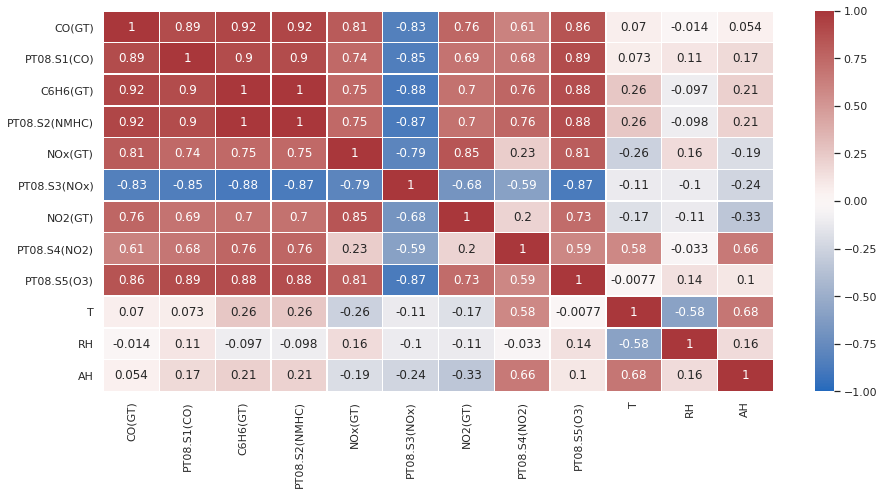

In [ ]:
# let's check correlations
corr_0 = train.drop(columns=["degree",  "month", "day"])
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr_0.corr(method='pearson'), vmin=-1, vmax=1, linewidths=0.5, cmap = 'vlag', annot=True)
plt.yticks(rotation = 0)
plt.show()

# We see a lot of correlated variables. 
# But we know that one of the assumptions for linear regression is the absence of multicollinearity.
# Honestly, I dont realy think that we need something except PT08.S2(NMHC)
# Because we obsereve super strong linear relationship
# But maybe it makes sence to check quality of the model with "T", "RH", "AH" and PT08.S5(O3)
# Or using PCA. Let's fing out

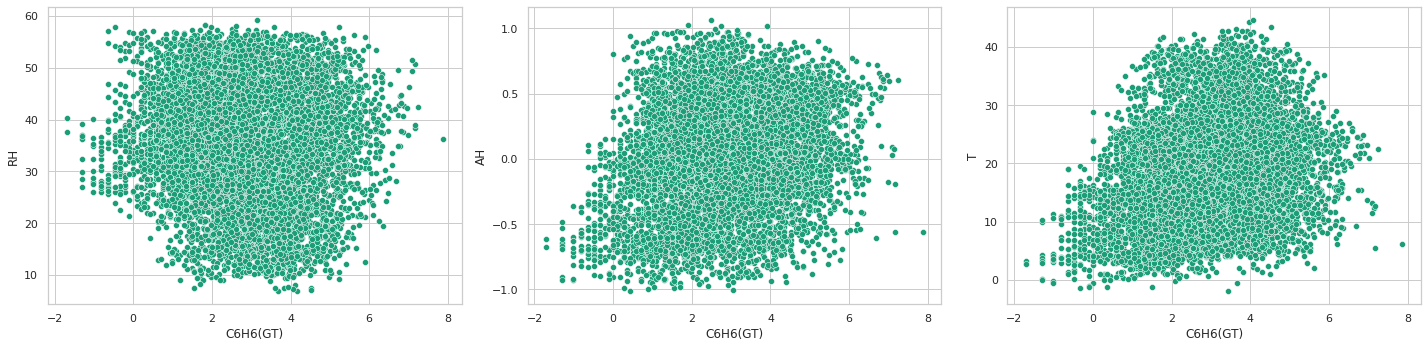

In [ ]:
# But first of all we need to check relationships between T, AH, RH and traget variable
fig, axes = plt.subplots(1,3, figsize=(20, 5))
sns.set(style="whitegrid", palette="Dark2")
sns.scatterplot(x = 'C6H6(GT)', y = 'RH', data=train.loc[:, ['C6H6(GT)', 'RH']], ax=axes[0])
sns.scatterplot(x = 'C6H6(GT)', y = 'AH', data=train.loc[:, ['C6H6(GT)', 'AH']], ax=axes[1])
sns.scatterplot(x = 'C6H6(GT)', y = 'T', data=train.loc[:, ['C6H6(GT)', 'T']], ax=axes[2])
plt.tight_layout()
plt.show()

# I consider we could drop RH there is no relationship with C6H6

In [ ]:
train.drop(columns=["RH"], inplace=True)

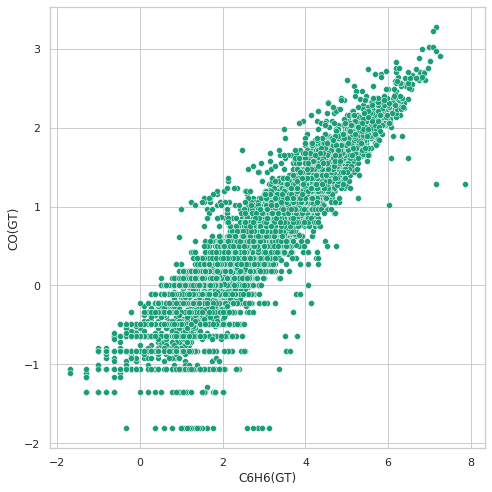

In [ ]:
# and lets look at CO(GT) 
fig = plt.figure(figsize=(7, 7))
sns.set(style="whitegrid", palette="Dark2")
sns.scatterplot(x = 'C6H6(GT)', y = 'CO(GT)', data=train.loc[:, ['C6H6(GT)', 'CO(GT)']])
plt.tight_layout()
plt.show()

In [ ]:
# It's looks strange. We should test model with this feature and without it. 
# train.drop(columns=["CO(GT)"], inplace=True)

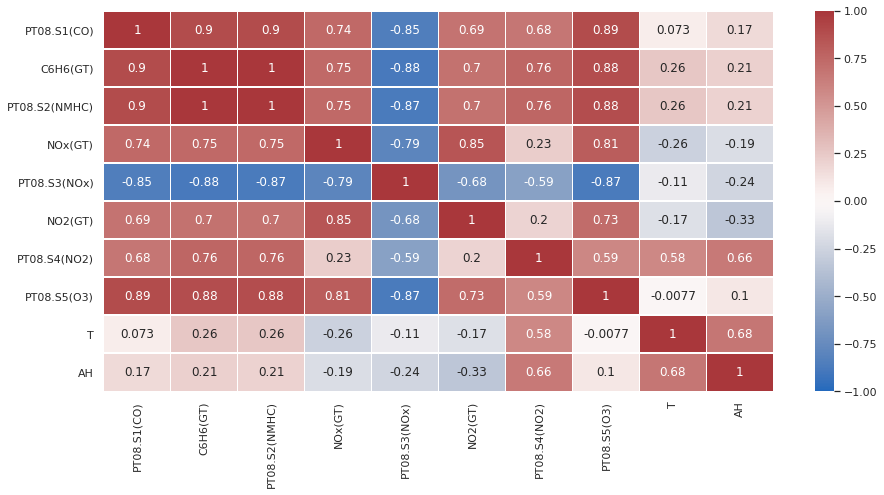

In [ ]:
corr_0 = train.drop(columns=["degree",  "month", "day"])
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr_0.corr(method='pearson'), vmin=-1, vmax=1, linewidths=0.5, cmap = 'vlag', annot=True)
plt.yticks(rotation = 0)
plt.show()

# Data Preparation. Part 2

Let's scale our features using StandardScaler and than drop outliers

In [ ]:
# StandardScaler
columns = train.columns.tolist()
for element in ["degree", "month", "day"]:
    columns.remove(element)

scaler = StandardScaler()
train.loc[:, columns] = scaler.fit_transform(train.loc[:, columns])

In [ ]:
# Remove outliers in a simple manner
shape_0 = train.shape[0]
train = train.loc[(np.abs(stats.zscore(train)) < 3).all(axis=1)]
print(f"found and deleted: {shape_0 - train.shape[0]} outliers")

found and deleted: 63 outliers


Before we will go forward, we need to decide what kind of cross-validation strategy we will use.

As we see we've got two super related variables. They represent the measurements of two devices, one of them is more accurate than another. Let's check if the divergence of these devices is different in a time. If divergence is really miscellaneous in different time intervals so it means we have to use time-series cross-validation. But if the divergence is stationary, then we can use K-FOLD cross-validation in this case.

In [ ]:
train["div"] = train.loc[:, 'C6H6(GT)'] - train.loc[:, 'PT08.S2(NMHC)']

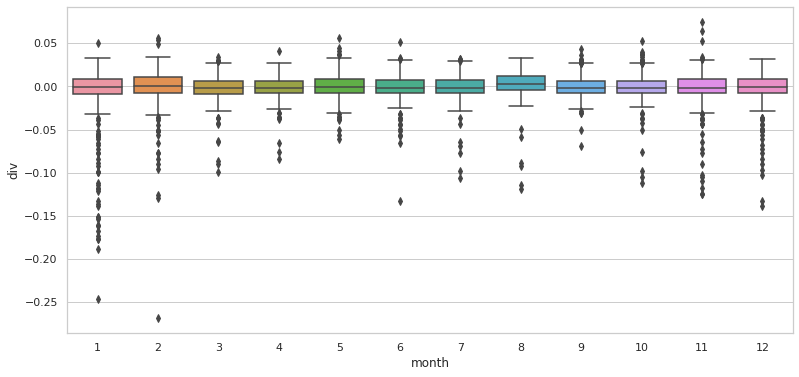

In [ ]:
# box plot "div"
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(13, 6))
train.loc[:, 'month'] = train.loc[:, 'month'].astype("int")
fig = sns.boxplot(x='month', y='div', data=train.loc[:, ['div', 'month']])
plt.show()


A stationary process is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.
If our series is exactly like this, there is no need to use timeseries cross validation.

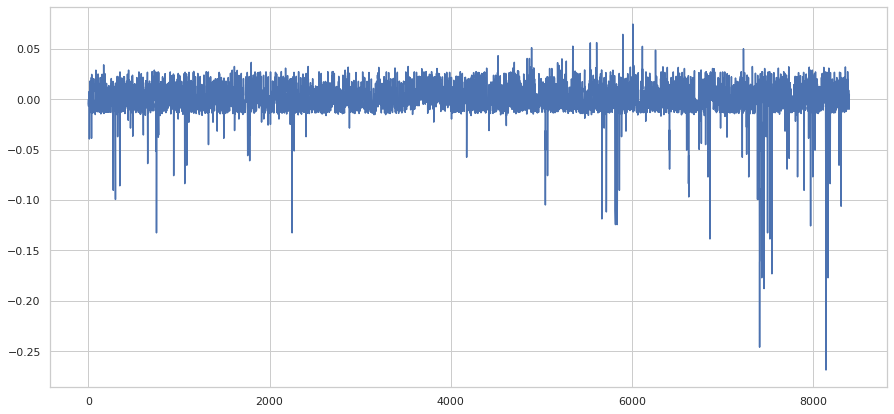

In [ ]:
# it seems like there is no trend or seasonal component
# the std looks stable over time
plt.figure(figsize=(15,7))
plt.plot(train["div"])
plt.show()

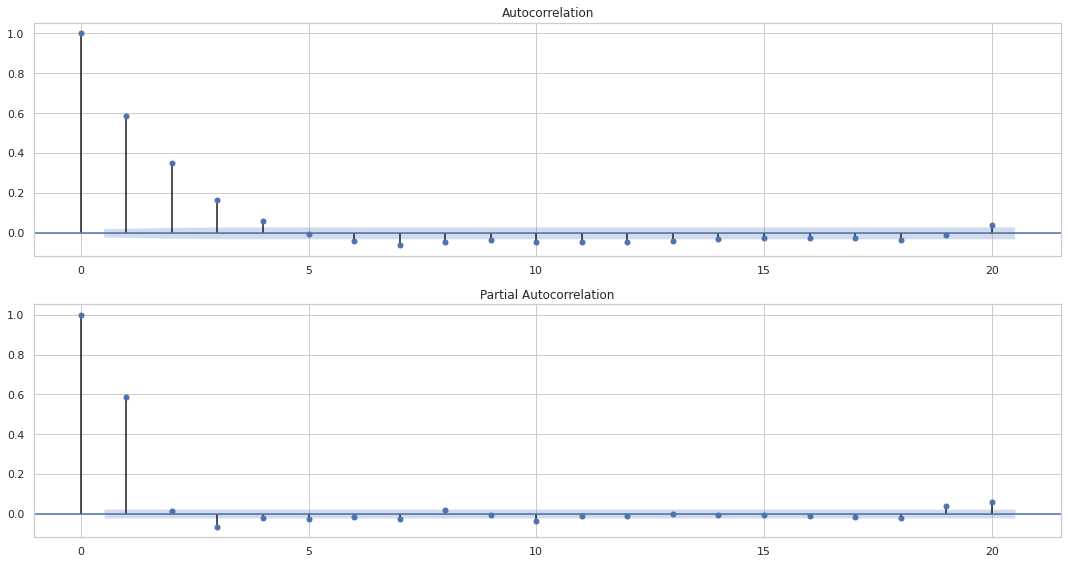

In [ ]:
import statsmodels.api as sm
# lets check ACF and PACF
# looking good. The values degrade to zero pretty quickly
fig , axes = plt.subplots(2, 1, figsize=(15,8))
sm.graphics.tsa.plot_acf(train["div"].values.squeeze(), lags=20, ax=axes[0])
sm.graphics.tsa.plot_pacf(train["div"].values.squeeze(), lags=20, ax=axes[1])
plt.tight_layout()
plt.show()

In [ ]:
# The Dickey-Fuller Test
# The null hypothesis that a unit root is present in an autoregressive model of a given time series
# The process is thus not stationary. 
print("The Dickey-Fuller Test: p-value=%f" % sm.tsa.stattools.adfuller(train["div"])[1])
# There is sufficient evidence at the level 0.0001 that the process is not stationary.

The Dickey-Fuller Test: p-value=0.000000


In [ ]:
# So it basicly means that we could use KFOLD cross-validation for our dataset.

In [ ]:
train.drop(columns=["month", "day"], inplace=True)

# Statistics model

lets build simple statistics model.  
We will use PT08.S2(NMHC), PT08.S5(O3) T, AH, degree as exogen variables  
And C6H6 as target

In [ ]:
import statsmodels.formula.api as smf

m1 = smf.ols('C6H6 ~ S2 + S5 + T + AH + degree',
             data=train.rename(columns= {"PT08.S2(NMHC)":"S2", 
                                        "PT08.S5(O3)":"S5", 
                                        "C6H6(GT)":"C6H6"})) 
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   C6H6   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.087e+06
Date:                Sun, 01 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:11:39   Log-Likelihood:                 22482.
No. Observations:                8338   AIC:                        -4.495e+04
Df Residuals:                    8332   BIC:                        -4.491e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.369e-05      0.000     -0.115      0.9

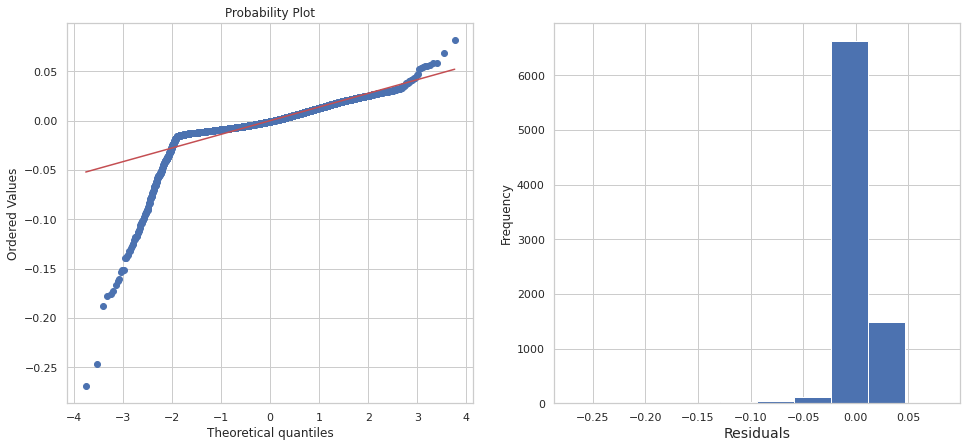

In [ ]:
# check residuals distribution
# the residuals are far from normal
plt.figure(figsize=(16,7))
plt.subplot(121)
stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.show()

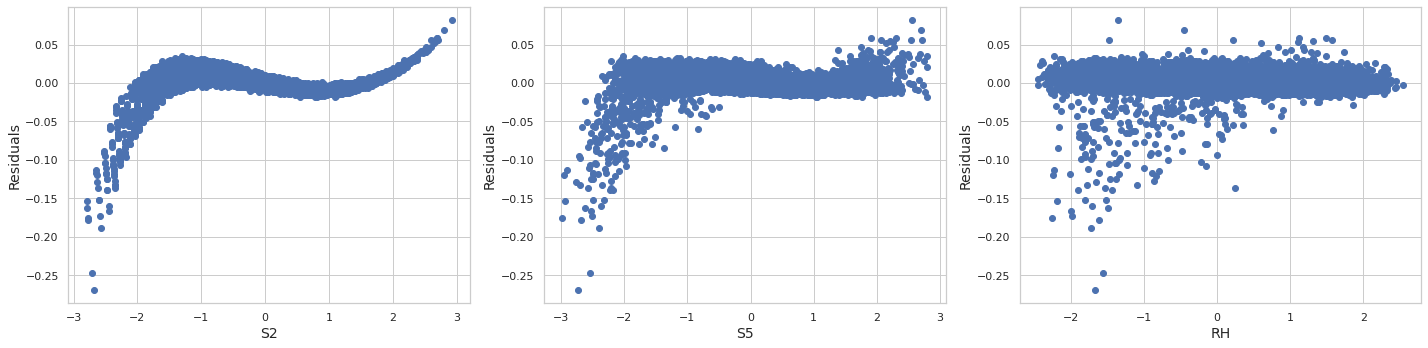

In [ ]:
# Scatter plot for exogen variables and residuals

plt.figure(figsize=(20,5))

plt.subplot(131)
plt.scatter(train['PT08.S2(NMHC)'], fitted.resid)
plt.xlabel('S2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.subplot(132)
plt.scatter(train["PT08.S5(O3)"], fitted.resid)
plt.xlabel('S5', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.subplot(133)
plt.scatter(train['AH'],fitted.resid)
plt.xlabel('RH', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.tight_layout()
plt.show()

We've got plenty of strange observations.  
And as we see 'PT08.S2 (NMHC)' distributed like a cubic parabola, not exactly  
but there is something in common. So let's add np.power(PT08.S2 (NMHC),3)

In [ ]:
import statsmodels.formula.api as smf

m1 = smf.ols('C6H6 ~ S2 + np.power(S2,3) + S5 + AH',
             data=train.rename(columns= {"PT08.S2(NMHC)":"S2", 
                                        "PT08.S5(O3)":"S5", 
                                        "C6H6(GT)":"C6H6"})) 
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   C6H6   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.440e+07
Date:                Sun, 01 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:28:35   Log-Likelihood:                 27340.
No. Observations:                8338   AIC:                        -5.467e+04
Df Residuals:                    8333   BIC:                        -5.463e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0003   9.99e-05     

PT08.S2(NMHC) is the most powerfull feature

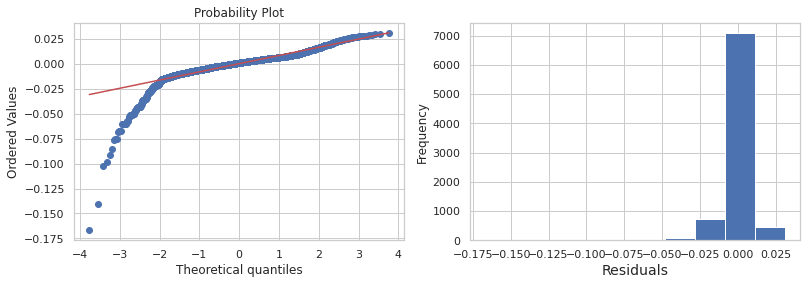

In [ ]:
# check residuals distribution
# it becomes better, but still not perfect
plt.figure(figsize=(13,4))
plt.subplot(121)
stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.show()

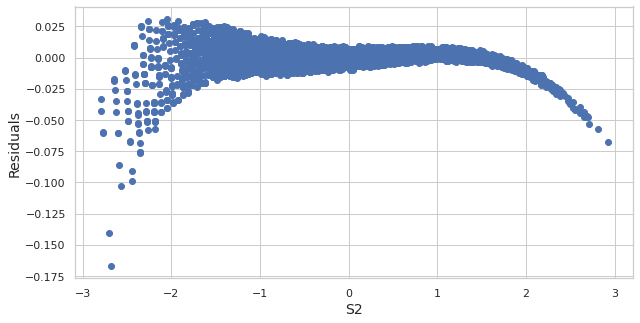

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(train['PT08.S2(NMHC)'], fitted.resid)
plt.xlabel('S2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

In [ ]:
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
# The Brousch-Pagan criterion to check the homoscedasticity of errors:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])
# Errors are heteroscedastic
# Not cool

Breusch-Pagan test: p=0.000000


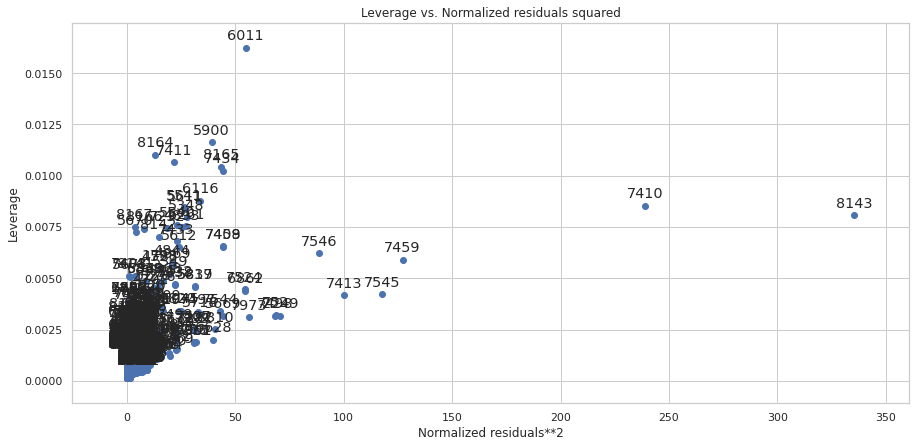

In [ ]:
# It seems like 8143, 7410 7459, 7545, 7413 7546 objects are not our friends
import matplotlib
with matplotlib.rc_context():
    matplotlib.rc("figure", figsize=(15,7))
    plot_leverage_resid2(fitted)
    plt.show()

In [ ]:
train.drop(index=[8143, 7410, 7459, 7545, 7413, 7546], inplace=True)

# Models

In [ ]:
data = pd.read_csv("./AirQualityUCI.csv", sep=';', decimal=',', parse_dates=True)
data.drop(columns=["Unnamed: 15", "Unnamed: 16"], inplace=True)
data.dropna(inplace=True)
data.replace(-200, np.nan, inplace=True)

# create new features
data.loc[:, 'hour'] = data.loc[:, 'Time'].str[:2].astype(int)
bin_low = [1, 2, 3, 4, 5, 6]
bin_high = [8, 9, 10, 17, 18, 19, 20]
bin_medium = [x for x in range(0, 24) if x not in bin_low+bin_high]
data.loc[:, 'degree'] = 1
data.loc[data["hour"].isin(bin_low), 'degree'] = 0
data.loc[data["hour"].isin(bin_high), 'degree'] = 2

# drop useless
data.drop(data.loc[data["AH"].isnull(), :].index, inplace=True)
data.drop(columns=["RH", "NMHC(GT)"], inplace=True)
# drop columns with NANs
data.drop(columns=["CO(GT)", 'NO2(GT)', 'NOx(GT)'], inplace=True)
data.drop(columns=["hour"], inplace=True)

In [ ]:
# split data
data.Date = pd.to_datetime(data.Date, dayfirst=True)
train = data.loc[(data.Date >= "2004-03-10") & (data.Date <= "2005-03-10")]
test = data.loc[data.Date > "2005-03-10"]
train.drop(columns=["Date", "Time"], inplace=True)
test.drop(columns=["Date", "Time"], inplace=True)

# x/y
x_train, y_train = train.drop(columns=['C6H6(GT)']), train.loc[:, ["C6H6(GT)"]]
x_test, y_test = test.drop(columns=['C6H6(GT)']), test.loc[:, ["C6H6(GT)"]]

## Pipelines

In [ ]:
# var_1: Powertransformer -> Scaler -> LR
columns_cont_var_1 = ["PT08.S2(NMHC)"]

# var_2: Powertransformer -> Scaler -> PCA -> Ridge
columns_cont_var_2 = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
                      'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH']

# var_3: Powertransformer -> Scaler -> Ridge and LR
columns_cont_var_3 = ['PT08.S2(NMHC)', 'PT08.S5(O3)', 'T', 'AH']

ordinal_column = ['degree']

In [ ]:
# piplines with transformations

pipeline_var_1 = Pipeline(steps=[
                                ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, columns_cont_var_1])),
                                ('box_cox', PowerTransformer(standardize=True)),              # BoxCox and Scaler
                                ])

pipeline_var_2 = Pipeline(steps=[
                                ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, columns_cont_var_2])),
                                ('box_cox', PowerTransformer( standardize=True)),              # BoxCox and Scaler
                                ])

pipeline_var_3 = Pipeline(steps=[
                                ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, columns_cont_var_3])),
                                ('box_cox', PowerTransformer(standardize=True)),              # BoxCox and Scaler
                                ])

ordinal_pipeline = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, ordinal_column]))
                              ])


In [ ]:
# union piplines
feature_union_var_1 = FeatureUnion(transformer_list = [
                                                 ("cont_pipeline", pipeline_var_1)
                                                 ]
                                   )

feature_union_var_2 = FeatureUnion(transformer_list = [
                                                 ("cont_pipeline", pipeline_var_2),
                                                 ("ordinal_pipeline", ordinal_pipeline)
                                                 ]
                                   )

feature_union_var_3 = FeatureUnion(transformer_list = [
                                                 ("cont_pipeline", pipeline_var_3),
                                                 ("ordinal_pipeline", ordinal_pipeline)
                                                 ]
                                   )

In [ ]:
# model piplines

linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)

estimator_var_1 = Pipeline(steps = [
                                  ('feature_processing', feature_union_var_1),
                                  ('model_fitting', linear_model) 
                                  ]
                                 )

estimator_var_2 = Pipeline(steps = [
                                  ('feature_processing', feature_union_var_2),
                                  ("pca", PCA(n_components=0.95)),
                                  ('model_fitting', ridge_model) 
                                  ]
                                 )

estimator_var_3 = Pipeline(steps = [
                                  ('feature_processing', feature_union_var_3),
                                  ('model_fitting', ridge_model) 
                                  ]
                                 )

In [ ]:
y_trans = PowerTransformer(method='box-cox', standardize=True)
y_trans.fit(y_train)

PowerTransformer(method='box-cox')

## GridSearch

In [ ]:
# determine search for var_2 and var_3
param_grid = {
    'model_fitting__alpha': [0.01, 0.1, 1, 10, 100],
}

# cross_val for var_1
quality = cross_val_score(estimator_var_1, x_train, y_trans.transform(y_train), cv=5, scoring='neg_mean_absolute_error')
estimator_var_1.fit(x_train, y_trans.transform(y_train))

# search for var_2
clf_2 = GridSearchCV(estimator_var_2, 
                   param_grid=param_grid, 
                   scoring='neg_mean_absolute_error', 
                   cv = 5, 
                   return_train_score=True 
                  )

# search for var_3
clf_3 = GridSearchCV(estimator_var_3,
                   param_grid=param_grid, 
                   scoring='neg_mean_absolute_error', 
                   cv = 5, 
                   return_train_score=True, 
                  )

## Fitting models

In [ ]:
# fit clf_2
clf_2.fit(x_train, y_trans.transform(y_train))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('cont_pipeline',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7f2c2783b710>)),
                                                                                        ('box_cox',
                                                                                         PowerTransformer())])),
                                                                       ('ordinal_pipeline',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7f2c2783be60>))]))])),
                                       ('pca', PCA(n_components=0.95)),
                                       ('model_fitting',
                                        Ridge(random_state=42))]),
             param_grid={'model_fitting__alpha': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
# fit clf_3
clf_3.fit(x_train, y_trans.transform(y_train))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('cont_pipeline',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7f2c2783ba70>)),
                                                                                        ('box_cox',
                                                                                         PowerTransformer())])),
                                                                       ('ordinal_pipeline',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x7f2c2783be60>))]))])),
                                       ('model_fitting',
                                        Ridge(random_state=42))]),
             param_grid={'model_fitting__alpha': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error')

## CV_curves

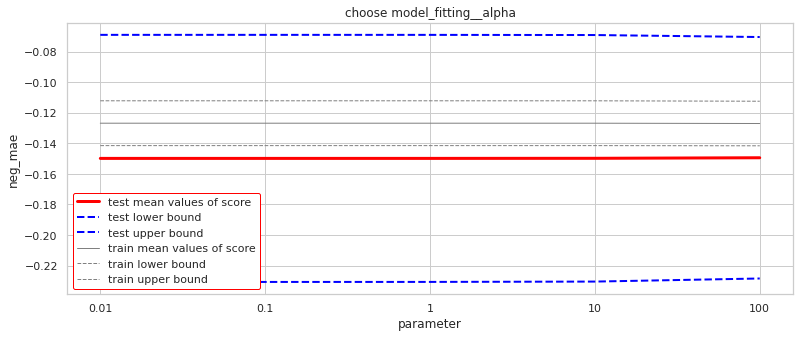

In [ ]:
# CV curves var_2
rs_df = pd.DataFrame(clf_2.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)
mean_train_score_var_2  = rs_df.loc[0, 'mean_train_score']

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

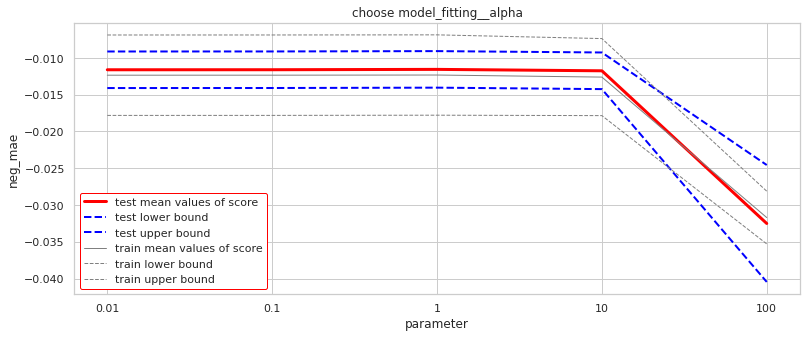

In [ ]:
# CV curves var_3
rs_df = pd.DataFrame(clf_3.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)
mean_train_score_var_3  = rs_df.loc[0, 'mean_train_score']

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

## train/test quality

In [ ]:
print(f"validation mean_mae var_1: {-quality.mean():0.03}")
print(f"validation mean_mae var_2: {-mean_train_score_var_2:0.03}")
print(f"validation mean_mae var_3: {-mean_train_score_var_3:0.03}")

validation mean_mae var_1: 0.0122
validation mean_mae var_2: 0.127
validation mean_mae var_3: 0.0123


In [ ]:
predict_1 = y_trans.inverse_transform(estimator_var_1.predict(x_test))
predict_2 = y_trans.inverse_transform(clf_2.best_estimator_.predict(x_test))
predict_3 = y_trans.inverse_transform(clf_3.best_estimator_.predict(x_test))

predict_1_train = y_trans.inverse_transform(estimator_var_1.predict(x_train))
predict_2_train = y_trans.inverse_transform(clf_2.best_estimator_.predict(x_train))
predict_3_train = y_trans.inverse_transform(clf_3.best_estimator_.predict(x_train))

In [ ]:
r2_var_1 = r2_score(y_test, predict_1)
r2_var_2 = r2_score(y_test, predict_2)
r2_var_3 = r2_score(y_test, predict_2)

r2_var_1_train = r2_score(y_train, predict_1_train)
r2_var_2_train = r2_score(y_train, predict_2_train)
r2_var_3_train = r2_score(y_train, predict_3_train)

In [ ]:
res_1 = y_train - predict_1_train
res_1.columns = ['residuals']
res_2 = y_train - predict_2_train
res_2.columns = ['residuals']
res_3 = y_train - predict_3_train
res_3.columns = ['residuals']

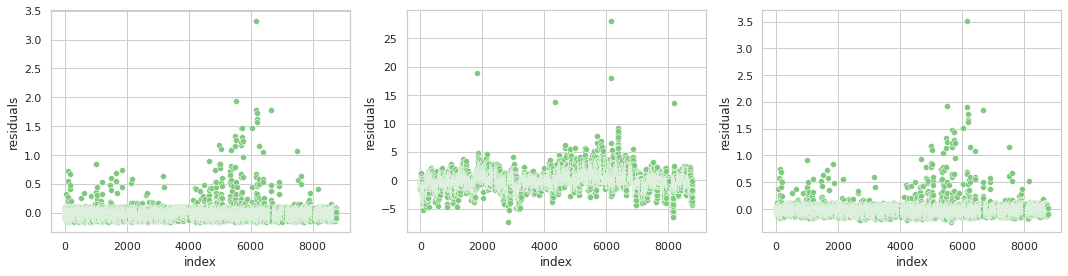

In [ ]:
# residuals plots
# var_1: axes[0]
# var_2: axes[1]
# var_3: axes[2]
# residuals are not normal, there are a lot of outliers in graph 1 and 3
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.scatterplot(x="index", y = "residuals",  data = res_1.reset_index(), ax=axes[0])
sns.scatterplot(x="index", y = "residuals",  data = res_2.reset_index(), ax=axes[1])
sns.scatterplot(x="index", y = "residuals",  data = res_3.reset_index(), ax=axes[2])
plt.tight_layout()
plt.show()

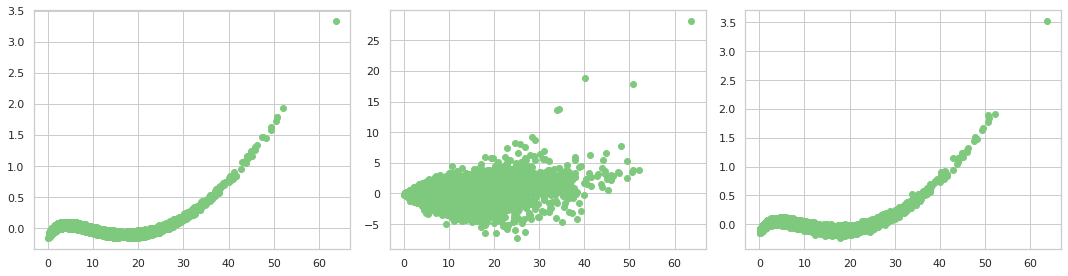

In [ ]:
# res are not random 
# we can extract additional info
fig, axes = plt.subplots(1,3, figsize=(15,4))
axes[0].scatter(y_train, res_1)
axes[1].scatter(y_train, res_2)
axes[2].scatter(y_train, res_3)
plt.tight_layout()
plt.show()

In [ ]:
mape_var_1 = mean_absolute_percentage_error(y_test, predict_1)
mape_var_2 = mean_absolute_percentage_error(y_test, predict_2)
mape_var_3 = mean_absolute_percentage_error(y_test, predict_3)

mape_var_1_train = mean_absolute_percentage_error(y_train, predict_1_train)
mape_var_2_train = mean_absolute_percentage_error(y_train, predict_2_train)
mape_var_3_train = mean_absolute_percentage_error(y_train, predict_3_train)

In [ ]:
print(f"r2_var_1_test: {r2_var_1:0.04},  r2_var_1_train: {r2_var_1_train:0.04}")
print(f"r2_var_2_test: {r2_var_2:0.04},  r2_var_2_train: {r2_var_2_train:0.04}")
print(f"r2_var_3_test: {r2_var_3:0.04},  r2_var_3_train: {r2_var_3_train:0.04}")

r2_var_1_test: 0.9999,  r2_var_1_train: 0.9997
r2_var_2_test: 0.9022,  r2_var_2_train: 0.9656
r2_var_3_test: 0.9022,  r2_var_3_train: 0.9997


In [ ]:
print(f"mape_var_1 test: {mape_var_1:0.04}, mape_var_1 train: {mape_var_1_train:0.04}")
print(f"mape_var_2 test: {mape_var_2:0.04}, mape_var_2 train: {mape_var_2_train:0.04}")
print(f"mape_var_3 test: {mape_var_3:0.04}, mape_var_3 train: {mape_var_3_train:0.04}")

mape_var_1 test: 0.009292, mape_var_1 train: 0.01075
mape_var_2 test: 0.2712, mape_var_2 train: 0.1084
mape_var_3 test: 0.009198, mape_var_3 train: 0.01069


PCA is not a good idea  
There is no diffrenece between var_1 and var_3 and they aare stable  
var_1 with only one PT08.S2(NMHC) performs pretty good.  

## Feature importance

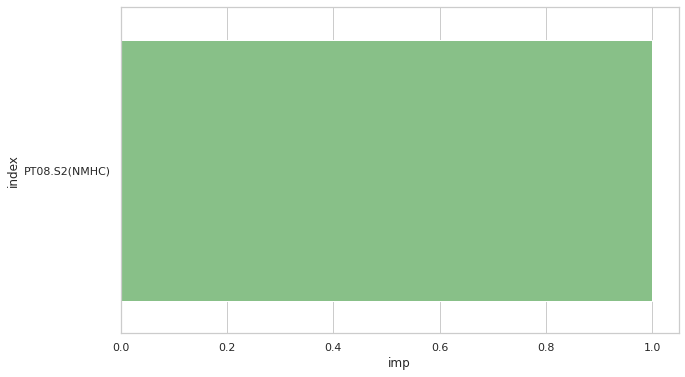

In [ ]:
imp_graph(estimator_var_1.named_steps['model_fitting'], columns=["PT08.S2(NMHC)"])

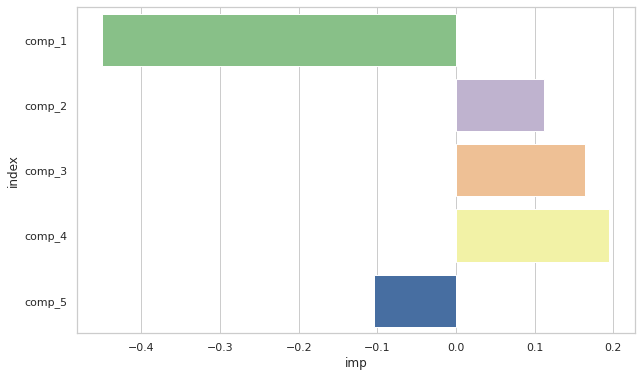

In [ ]:
imp_graph(clf_2.best_estimator_.named_steps['model_fitting'], columns=['comp_1', "comp_2", "comp_3", "comp_4", "comp_5"])

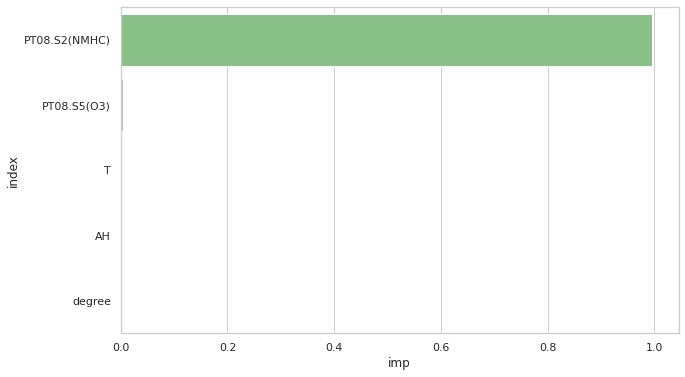

In [ ]:
imp_graph(clf_3.best_estimator_.named_steps['model_fitting'], columns=['PT08.S2(NMHC)', 'PT08.S5(O3)', 'T', 'AH', 'degree'])